In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [164]:
# load
loan_result=pd.read_csv("../data/loan_result.csv")
log_data=pd.read_csv("../data/log_data.csv")
user_spec=pd.read_csv("../data/user_spec.csv")

# columns localize
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯

In [165]:
log_data=log_data.drop_duplicates()
user_spec=user_spec.drop_duplicates()

In [166]:
# log_data sort by time(asc)
log_data=log_data.sort_values('행동일시').reset_index(drop=True)
log_data.head()

,유저_번호,행동명,행동일시,운영체제,앱_버전,일_코드
0,720911,OpenApp,2022-03-01 00:00:00,iOS,3.6.0,2022-03-01
1,385811,Login,2022-03-01 00:00:00,Android,3.8.0,2022-03-01
2,125129,UseLoanManage,2022-03-01 00:00:00,Android,3.8.0,2022-03-01
3,706858,GetCreditInfo,2022-03-01 00:00:03,android,417,2022-03-01
4,512341,EndLoanApply,2022-03-01 00:00:03,Android,3.8.0,2022-03-01


In [167]:
# Datetime 변환
log_data['행동일시'] = pd.to_datetime(log_data['행동일시'])
log_data['일_코드'] = pd.to_datetime(log_data['일_코드'])
loan_result['한도조회_일시'] = pd.to_datetime(loan_result['한도조회_일시'])
user_spec['생성일시'] = pd.to_datetime(user_spec['생성일시'])

In [168]:
log_data[log_data['유저_번호']==12]

,유저_번호,행동명,행동일시,운영체제,앱_버전,일_코드
1579216,12,OpenApp,2022-03-14 01:13:11,Android,3.8.0,2022-03-14
1579218,12,Login,2022-03-14 01:13:15,Android,3.8.0,2022-03-14
1579219,12,StartLoanApply,2022-03-14 01:13:21,Android,3.8.0,2022-03-14
1579220,12,ViewLoanApplyIntro,2022-03-14 01:13:22,Android,3.8.0,2022-03-14
1579230,12,CompleteIDCertification,2022-03-14 01:13:46,Android,3.8.0,2022-03-14
...,...,...,...,...,...,...
17274137,12,StartLoanApply,2022-06-30 14:46:53,Android,3.15.1,2022-06-30
17274141,12,ViewLoanApplyIntro,2022-06-30 14:46:53,Android,3.15.1,2022-06-30
17274203,12,CompleteIDCertification,2022-06-30 14:47:13,Android,3.15.1,2022-06-30
17274740,12,EndLoanApply,2022-06-30 14:49:45,Android,3.15.1,2022-06-30


In [170]:
log_data[log_data['유저_번호']==879698]

,유저_번호,행동명,행동일시,운영체제,앱_버전,일_코드
11585096,879698,OpenApp,2022-05-24 22:33:24,iOS,NaN,2022-05-24
11585113,879698,ViewLoanApplyIntro,2022-05-24 22:33:32,iOS,NaN,2022-05-24
11585114,879698,StartLoanApply,2022-05-24 22:33:32,iOS,NaN,2022-05-24


In [7]:
# user_spec & log_data
users=set(user_spec['유저_번호'])
log_user=set(log_data['유저_번호'])
count=[]

for num in log_user:
    if num in users:
        count.append(num)

print(len(count))

370436


## 주요 경로
### 1. 경로의 종류
#### 1) 5개의 스크린
- 한도조회인트로페이지조회(ViewLoanApplyIntro), 대출관리서비스 이용(UseLoanManage), 여윳돈 계산기 이용(UsePrepayCalc), DSR 계산기 이용(UseDSRCalc), KCB 신용정보 조회(GetCreditInfo)
- ['ViewLoanApplyIntro', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo']
- +a로 퍼널 포함
- ['ViewLoanApplyIntro', 'StartLoanApply', 'CompleteIDCertification', 'EndLoanApply', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo']
#### 2) 시작점-종료점
- OpenApp부터 그 다음 OpenApp 까지

### 2. 슬라이싱
- 0. log_data에서 5개의 스크린만 뽑기
- 1. log_data를 user별로 
- 2. OpenApp 앞뒤를 쪼개서 여러개의 리스트로 합친
- 3. 전체 route_list에 넣음
- 4. 겹치는 것의 종류 확인
    + 5!+4!+3!+2!+1!=153 보다 많다면 쪼개야하나.. 일단 최대 길이 찾아서 대기..
- 5. value_counts()

In [8]:
screens = ['ViewLoanApplyIntro', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo', 
           'StartLoanApply', 'CompleteIDCertification', 'EndLoanApply']
main_route_log_df=log_data[(log_data['행동명']=="OpenApp")|
                           (log_data['행동명']==screens[0])|
                           (log_data['행동명']==screens[1])|
                           (log_data['행동명']==screens[2])|
                           (log_data['행동명']==screens[3])|
                           (log_data['행동명']==screens[4])|
                           (log_data['행동명']==screens[5])|
                           (log_data['행동명']==screens[6])|
                           (log_data['행동명']==screens[7])
                           ]
main_route_log_df.reset_index(drop=True, inplace=True)
len(main_route_log_df), len(log_data), len(set(main_route_log_df['유저_번호']))

(14861363, 17359850, 577860)

#### OpenApp 기준 슬라이싱

In [89]:
users=list(set(main_route_log_df['유저_번호']))
route_list=[]
user_list=[]

count_op=0

# target의 idx들(복수)를 list로 추출
def list_idx(arr, target):
    return [i for i in range(len(arr)) if arr[i]==target]

# 유저별로 OpenApp 기준 슬라이싱
for i in tqdm(range(len(users))):
    df=main_route_log_df[main_route_log_df['유저_번호']==users[i]]
    idx_list=list_idx(list(df['행동명']), 'OpenApp')
    if len(idx_list)>0 and len(df)>0:
        for j in range(len(idx_list)):
            start=idx_list[j]
            try:
                end=idx_list[j+1]
                route_list.append(list(df['행동명'].iloc[start:end]))
                user_list.append(users[i])
            except IndexError:
                count_op+=1
                route_list.append(list(df['행동명'].iloc[start:]))
                user_list.append(users[i])
            
        # route_list.append([df['행동명'].iloc[idx_list[i]:min(idx_list[i+1], len(df))] for i in range(len(idx_list))])
    else: continue

100%|██████████| 577860/577860 [39:11<00:00, 245.71it/s] 


In [130]:
max(user_list), count_op, len(user_list)


(879698, 418602, 3456728)

- route_list와 user_list가 같은 idx를 공유

In [131]:
len(route_list), len(user_list) # 같아야 함

(3456728, 3456728)

In [132]:
np.save('../data/route_list', np.array(route_list)) # 모든 루트
np.save('../data/user_list', np.array(user_list)) # 해당 루트의 유저 번호(동일 idx)

## 경로
- 5개의 스크린을 기준으로 1~5개의 순서에 대한 permutation을 돌림
- 0개부터 5개까지 [1 + 5 + 5*4 + 5*4*3 + 5*4*3*2 + 5*4*3*2*1 = **326**]
- **326가지의 루트**가 있다

In [171]:
from asyncore import poll3
from itertools import permutations
from itertools import combinations

log_init=[('ViewLoanApplyIntro'), ('UseLoanManage'), ('UsePrepayCalc'), ('UseDSRCalc'), ('GetCreditInfo')]
log_columns = [('ViewLoanApplyIntro'), ('UseLoanManage'),
               ('UsePrepayCalc'), ('UseDSRCalc'), ('GetCreditInfo')]

p2=list(permutations(log_init, 2))
p3=list(permutations(log_init, 3))
p4=list(permutations(log_init, 4))
p5=list(permutations(log_init, 5))

n1=5
n2=len(p2)
n3=len(p3)
n4=len(p4)
n5=len(p5)

for arr in p2:
    log_columns.append(arr)
for arr in p3:
    log_columns.append(arr)
for arr in p4:
    log_columns.append(arr)
for arr in p5:
    log_columns.append(arr)
    
log_columns.append((''))

# 퍼널 용도 추가
log_columns.append(tuple(('StartLoanApply', 'ViewLoanApplyIntro')))
log_columns.append(tuple(('ViewLoanApplyIntro', 'StartLoanApply')))
log_columns.append(tuple(('StartLoanApply', 'CompleteIDCertification')))
log_columns.append(tuple(('CompleteIDCertification', 'EndLoanApply')))

len(log_columns), n1+n2+n3+n4+n5+1 # 5개의 스크린의 1, 2, 3, 4, 5 순열 합

(330, 326)

- 아무 활동도 하지 않은 경로의 개수

In [172]:
log_ngram_df=pd.DataFrame([0]*len(log_columns), index=log_columns, columns=['count'])
users_noroute=[]
count=0
for i in range(len(route_list)):
    if len(route_list[i])==1: 
        count+=1
        users_noroute.append(user_list[i])
log_ngram_df.loc['']=count

print("%d명의 유저가 경로가 없음."%(len(users_noroute)))
log_ngram_df

943467명의 유저가 경로가 없음.


,count
ViewLoanApplyIntro,0
UseLoanManage,0
UsePrepayCalc,0
UseDSRCalc,0
GetCreditInfo,0
...,...
,943467
"(StartLoanApply, ViewLoanApplyIntro)",0
"(ViewLoanApplyIntro, StartLoanApply)",0
"(StartLoanApply, CompleteIDCertification)",0


In [173]:
route_list[0]

['OpenApp',
 'GetCreditInfo',
 'UseLoanManage',
 'GetCreditInfo',
 'UsePrepayCalc',
 'ViewLoanApplyIntro',
 'StartLoanApply',
 'CompleteIDCertification',
 'EndLoanApply',
 'UseLoanManage',
 'GetCreditInfo']

In [174]:
users_noroute[:5]

[20, 20, 20, 20, 20]

In [175]:
# 역색인용 dict
log_dict={}
for col in log_columns:
    log_dict[str(col)]=[]
    
len(log_dict.keys())

330

In [176]:
# screens=['ViewLoanApplyIntro', 'UseLoanManage', 'UsePrepayCalc', 'UseDSRCalc', 'GetCreditInfo']

# 조합별 개수 count와 역색인용 Dict 함께 돌리기
for i in tqdm(range(len(route_list))):
    if len(route_list[i])==1: continue
    for n in range(1, len(route_list[i])):
        # 원소 안의 2~5개의 순서 지킨 조합에서
            # range에서도 1 빠지고 슬라이싱에서도 1 빠져서 머리 터지는 줄
        for k in range(n+1, min(n+1+5, len(route_list[i])+1)):
            # print(tuple(route_list[i][n:k]))
            # 하나일 때랑 여러개 일 때 들어가는 [] 계층이 다름
            if len(route_list[i][n:k])==1: 
                try:
                    # count
                    log_ngram_df.loc[route_list[i][n:k]]+=1
                    # dict
                    log_dict[str(route_list[i][n:k][0])].append(i)
                except: continue
            else: 
                try: 
                    # count
                    log_ngram_df.loc[[tuple(route_list[i][n:k])]]+=1
                    # dict
                    log_dict[str(tuple(route_list[i][n:k]))].append(i)
                except KeyError:
                    continue
log_ngram_df.head()

100%|██████████| 3456728/3456728 [2:16:15<00:00, 422.79it/s]  


,count
ViewLoanApplyIntro,1601168
UseLoanManage,1402808
UsePrepayCalc,5705
UseDSRCalc,3660
GetCreditInfo,2073473


In [177]:
# 역색인을 위한 dict 중복 제거 하면 안 돼!!
# for key in list(log_dict.keys()):
#     log_dict[key]=list(set(log_dict[key]))

In [178]:
log_dict_user=log_dict.copy()

for key in log_dict.keys():
    users=[]
    for i in range(len(log_dict[key])):
        users.append(user_list[log_dict[key][i]])
        
    #users=list(set(users))
    users.sort()
    
    log_dict_user[key]=users

In [179]:
log_ngram_df.to_csv("../data/log_ngram_df.csv", index=False)
np.save('../data/log_columns.npy' ,log_columns)

import pickle

with open('../data/log_dict.pkl','wb') as f:
    pickle.dump(log_dict,f)
    
with open('../data/log_dict_user.pkl','wb') as f:
    pickle.dump(log_dict_user,f)

# with open('data_dict.pkl','rb') as f:
#     mydict = pickle.load(f)

In [181]:
log_ngram_df # 하... ㅅㅂ.... 왜이렇게 많은데

,count
ViewLoanApplyIntro,1601168
UseLoanManage,1402808
UsePrepayCalc,5705
UseDSRCalc,3660
GetCreditInfo,2073473
...,...
,943467
"(StartLoanApply, ViewLoanApplyIntro)",658613
"(ViewLoanApplyIntro, StartLoanApply)",487270
"(StartLoanApply, CompleteIDCertification)",338360


---

## 시각화

- df로 그래프 그려줌

In [182]:
def plot_log_cols(log_columns_df, n=-1, rotation=45):
    if n==-1: n=len(log_columns_df)
    log_columns_str=[str(x) for x in log_columns_df.index]
    plt.bar(log_columns_str[:n], log_columns_df.iloc[:n]['count'])
    plt.xticks(log_columns_str[:n], rotation=rotation, fontsize=8)
    plt.show()

In [183]:
n1, n2, n3, n4, n5

(5, 20, 60, 120, 120)

In [184]:
log_ngram_df.iloc[:n1]['count']

ViewLoanApplyIntro    1601168
UseLoanManage         1402808
UsePrepayCalc            5705
UseDSRCalc               3660
GetCreditInfo         2073473
Name: count, dtype: int64

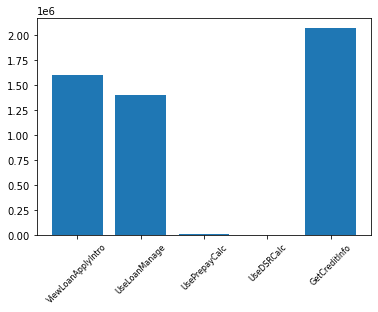

In [185]:
plot_log_cols(log_ngram_df, n1)

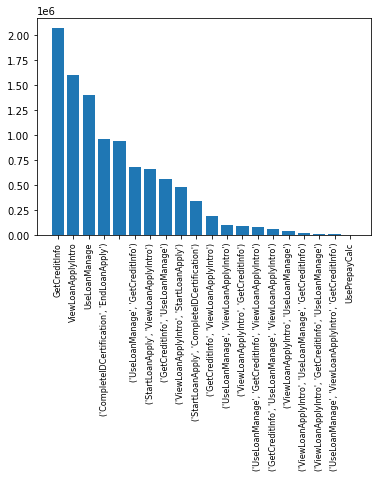

In [186]:
# 개수 순으로 정렬
log_ngram_sort_df=log_ngram_df.sort_values(by=['count'], ascending=False)
plot_log_cols(log_ngram_sort_df, n=20, rotation=90)


In [187]:
log_ngram_sort_df.head(20) 

,count
GetCreditInfo,2073473
ViewLoanApplyIntro,1601168
UseLoanManage,1402808
"(CompleteIDCertification, EndLoanApply)",966778
,943467
"(UseLoanManage, GetCreditInfo)",681171
"(StartLoanApply, ViewLoanApplyIntro)",658613
"(GetCreditInfo, UseLoanManage)",565956
"(ViewLoanApplyIntro, StartLoanApply)",487270
"(StartLoanApply, CompleteIDCertification)",338360


- 상위 15% 파싱(min 190, count 48)

In [188]:
log_ngram_sort_df_15=log_ngram_sort_df[:int(len(log_ngram_sort_df)*0.15)]
log_ngram_sort_df_15.describe()

,count
count,4.900000e+01
mean,2.116394e+05
std,4.587222e+05
min,2.280000e+02
25%,3.820000e+02
50%,1.872000e+03
75%,9.232600e+04
max,2.073473e+06


- 첫 스크린 별로

In [189]:
screens
# SL, UL, UP, UD, GC

['ViewLoanApplyIntro',
 'UseLoanManage',
 'UsePrepayCalc',
 'UseDSRCalc',
 'GetCreditInfo',
 'StartLoanApply',
 'CompleteIDCertification',
 'EndLoanApply']

In [190]:
SL=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[0] or x==screens[0]]
UL=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[1] or x==screens[1]]
UP=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[2] or x==screens[2]]
UD=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[3] or x==screens[3]]
GC=[x for x in log_ngram_sort_df_15.drop(['']).index if x[0]==screens[4] or x==screens[4]]

In [191]:
# log_ngram_sort_df_15.loc[[list(list(SL)[0])]]
SL_df=log_ngram_sort_df_15.loc[list(SL)]
UL_df=log_ngram_sort_df_15.loc[list(UL)]
UP_df=log_ngram_sort_df_15.loc[list(UP)]
UD_df=log_ngram_sort_df_15.loc[list(UD)]
GC_df=log_ngram_sort_df_15.loc[list(GC)]

In [192]:
def plot_log_cols_info(log_columns_df, n=-1, rotation=45):
    if n==-1: n=len(log_columns_df)
    log_columns_str=[str(x) for x in log_columns_df.index]
    plt.title(log_columns_str[0]+"의 분포")
    plt.bar(log_columns_str[:n], log_columns_df.iloc[:n]['count'])
    plt.xticks(log_columns_str[:n], rotation=rotation, fontsize=8)
    plt.show()
    print(log_columns_df.describe())

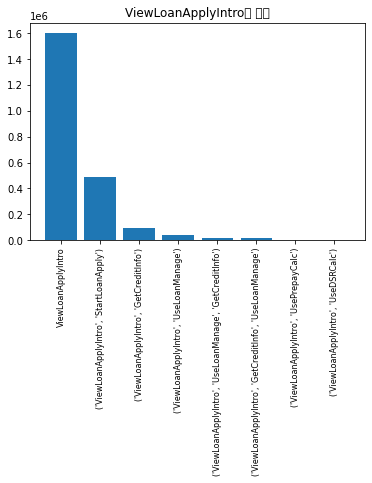

              count
count  8.000000e+00
mean   2.821565e+05
std    5.574194e+05
min    2.560000e+02
25%    1.253825e+04
50%    2.964350e+04
75%    1.910620e+05
max    1.601168e+06


In [193]:
plot_log_cols_info(SL_df, rotation=90)

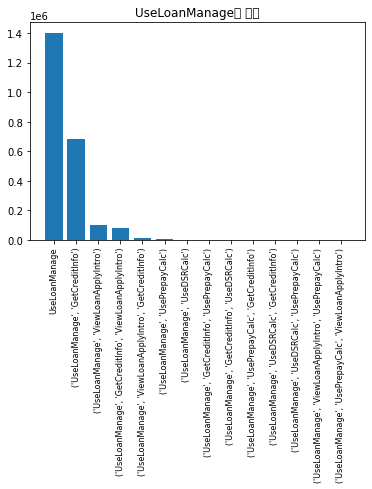

              count
count  1.400000e+01
mean   1.629870e+05
std    3.996639e+05
min    2.390000e+02
25%    3.677500e+02
50%    1.405000e+03
75%    6.371200e+04
max    1.402808e+06


(None,)

In [194]:
plot_log_cols_info(UL_df, rotation=90), 


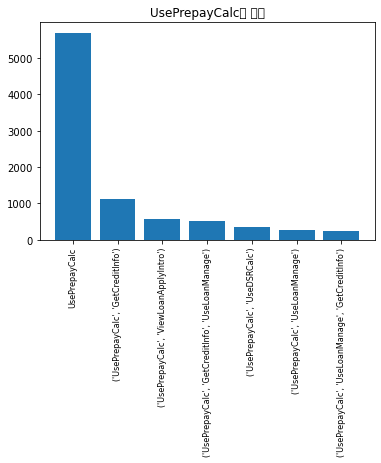

             count
count     7.000000
mean   1254.714286
std    1985.695320
min     228.000000
25%     309.500000
50%     526.000000
75%     852.500000
max    5705.000000


(None,)

In [195]:
plot_log_cols_info(UP_df, rotation=90), 

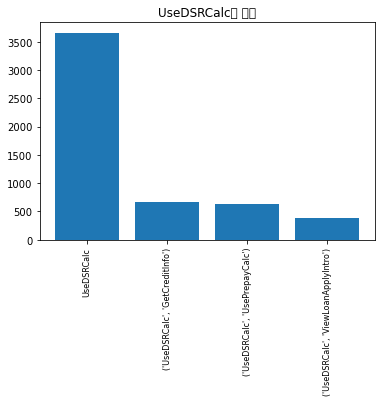

             count
count     4.000000
mean   1336.000000
std    1554.608632
min     382.000000
25%     568.000000
50%     651.000000
75%    1419.000000
max    3660.000000


(None,)

In [196]:
plot_log_cols_info(UD_df, rotation=90), 

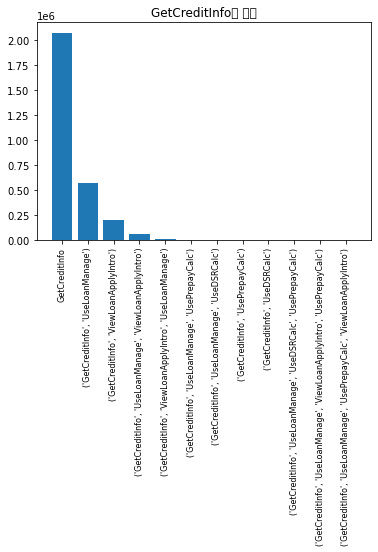

              count
count  1.200000e+01
mean   2.424930e+05
std    5.997095e+05
min    2.300000e+02
25%    7.960000e+02
50%    2.085000e+03
75%    9.580900e+04
max    2.073473e+06


In [197]:
plot_log_cols_info(GC_df, rotation=90)

- 색인

In [198]:
log_columns[:10]

['ViewLoanApplyIntro',
 'UseLoanManage',
 'UsePrepayCalc',
 'UseDSRCalc',
 'GetCreditInfo',
 ('ViewLoanApplyIntro', 'UseLoanManage'),
 ('ViewLoanApplyIntro', 'UsePrepayCalc'),
 ('ViewLoanApplyIntro', 'UseDSRCalc'),
 ('ViewLoanApplyIntro', 'GetCreditInfo'),
 ('UseLoanManage', 'ViewLoanApplyIntro')]

In [199]:
# 중요도?
log_ngram_sort_df_15['rank']=[x for x in range(1, 50)]
log_ngram_sort_df_15

,count,rank
GetCreditInfo,2073473,1
ViewLoanApplyIntro,1601168,2
UseLoanManage,1402808,3
"(CompleteIDCertification, EndLoanApply)",966778,4
,943467,5
"(UseLoanManage, GetCreditInfo)",681171,6
"(StartLoanApply, ViewLoanApplyIntro)",658613,7
"(GetCreditInfo, UseLoanManage)",565956,8
"(ViewLoanApplyIntro, StartLoanApply)",487270,9
"(StartLoanApply, CompleteIDCertification)",338360,10


In [201]:
log_ngram_sort_df_15.to_csv("../data/log_ngram_sort_df_15.csv")

# user_spec에 추가
1. 주 경로에 대한 유저별 count(12개)

```python
cols=['UG', 'GU', 'GV', 'UV', 'VG', 'UGV', 'GUV', 'VU', 'VUG', 'VGU', 'UVG', 'GVU']
# log_dict_user 이용하면 될듯
```

2. 퍼널별 회수 추가
- 각각 'VS', 'SC', 'CE'
```python
funnel_count_cols=['funnel_10', 'funnel_21', 'funnel_32']
# log_dict_user 이용하면 될듯
```


___

## 연관성 분석: 

1. Apriori algorithm [링크](https://hezzong.tistory.com/23)

- 지지도(support) : 한 거래 항목 안에 A와 B를 동시에 포함하는 거래의 비율. 지지도는 A와 B가 함께 등장할 확률이다. 전체 거래의 수를 A와 B가 동시에 포함된 거래수를 나눠주면 구할 수 있다.
- 신뢰도(confidence) : 항목 A가 포함하는 거래에 A와 B가 같이포함될 확률. 신뢰도는 조건부 확률과 유사하다. A가 일어났을 때 B의 확률이다. A의 확률을 A와 B가 동시에 포함될 확률을 나눠주면 구할 수 있다.
- 향상도(lift) : A가 주어지지 않을 때의 품목 B의 확률에 비해 A가 주어졌을 때 품목 B의 증가 비율. B의 확률이 A가 일어났을 때 B의 확률을 나눴을 때 구할 수 있다. lift 값은 1이면 서로 독립적인 관계이며1보다 크면 두 품목이 서로 양의 상관관계, 1보다 작으면 두 품목이 서로 음의 상관관계이다. A와 B가 독립이면 분모, 분자가 같기 때문에 1이 나온다.

2. FP-Growth algorithm 

3. DHP algorithm

In [43]:
## 필터링..을 하기엔 너무 큰데.. 역색인으로 해놔서 괜찮은갈랑가
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [44]:
r_list=list(np.load('../data/route_list.npy', allow_pickle=True)) # 모든 루트
len(r_list)

3460762

In [45]:
# 연관 분석 정확도를 위하여 단일 행동 이하는 삭제
route_list_duple=[]
for i in tqdm(range(len(r_list))):
    if len(r_list[i])>2: route_list_duple.append(r_list[i])
    else: continue
len(route_list_duple)

100%|██████████| 3460762/3460762 [00:01<00:00, 2971948.11it/s]


1312737

In [46]:
te = TransactionEncoder()
te_ary=te.fit(route_list_duple).transform(route_list_duple)
df=pd.DataFrame(te_ary, columns=te.columns_)
df.drop(['OpenApp'], axis=1, inplace=True)
df.head()

,GetCreditInfo,UseDSRCalc,UseLoanManage,UsePrepayCalc,ViewLoanApplyIntro
0,True,False,True,True,True
1,True,False,True,False,True
2,True,False,True,False,True
3,True,False,True,False,True
4,True,False,False,False,True


In [47]:
# supprot higher than 0.5
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.892145,(GetCreditInfo)
1,0.748525,(UseLoanManage)
2,0.534673,(ViewLoanApplyIntro)
3,0.701786,"(GetCreditInfo, UseLoanManage)"
4,0.437216,"(GetCreditInfo, ViewLoanApplyIntro)"
5,0.316354,"(ViewLoanApplyIntro, UseLoanManage)"
6,0.280011,"(GetCreditInfo, ViewLoanApplyIntro, UseLoanMan..."


UseLoanManage와 GetCreditInfo 사이에는 양의 상관관계가 있다

In [48]:
apriori_df=association_rules(frequent_itemsets, metric="lift", min_threshold=0)
apriori_df[apriori_df['confidence']>0.7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GetCreditInfo),(UseLoanManage),0.892145,0.748525,0.701786,0.786627,1.050904,0.033993,1.178573
1,(UseLoanManage),(GetCreditInfo),0.748525,0.892145,0.701786,0.937559,1.050904,0.033993,1.727294
3,(ViewLoanApplyIntro),(GetCreditInfo),0.534673,0.892145,0.437216,0.817727,0.916585,-0.039790,0.591720
8,"(ViewLoanApplyIntro, UseLoanManage)",(GetCreditInfo),0.316354,0.892145,0.280011,0.885119,0.992124,-0.002223,0.938838


In [49]:
frequent_itemsets_fp=fpgrowth(df, min_support=0.1, use_colnames=True)
frequent_itemsets_fp.head()

,support,itemsets
0,0.892145,(GetCreditInfo)
1,0.748525,(UseLoanManage)
2,0.534673,(ViewLoanApplyIntro)
3,0.701786,"(GetCreditInfo, UseLoanManage)"
4,0.437216,"(GetCreditInfo, ViewLoanApplyIntro)"


In [50]:
fp_df=association_rules(frequent_itemsets_fp, metric="lift", min_threshold=0)
fp_df[fp_df['confidence']>0.7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GetCreditInfo),(UseLoanManage),0.892145,0.748525,0.701786,0.786627,1.050904,0.033993,1.178573
1,(UseLoanManage),(GetCreditInfo),0.748525,0.892145,0.701786,0.937559,1.050904,0.033993,1.727294
3,(ViewLoanApplyIntro),(GetCreditInfo),0.534673,0.892145,0.437216,0.817727,0.916585,-0.039790,0.591720
8,"(ViewLoanApplyIntro, UseLoanManage)",(GetCreditInfo),0.316354,0.892145,0.280011,0.885119,0.992124,-0.002223,0.938838


## 군집화
idx: user

col: 326가지 중복 제외 경로

In [51]:
# log_dict_user, log_columns
cluster_df=pd.DataFrame([[0]*326]*370436, columns=log_columns)
cluster_df.head()

,ViewLoanApplyIntro,UseLoanManage,UsePrepayCalc,UseDSRCalc,GetCreditInfo,"(ViewLoanApplyIntro, UseLoanManage)","(ViewLoanApplyIntro, UsePrepayCalc)","(ViewLoanApplyIntro, UseDSRCalc)","(ViewLoanApplyIntro, GetCreditInfo)","(UseLoanManage, ViewLoanApplyIntro)",...,"(GetCreditInfo, UsePrepayCalc, UseLoanManage, UseDSRCalc, ViewLoanApplyIntro)","(GetCreditInfo, UsePrepayCalc, UseDSRCalc, ViewLoanApplyIntro, UseLoanManage)","(GetCreditInfo, UsePrepayCalc, UseDSRCalc, UseLoanManage, ViewLoanApplyIntro)","(GetCreditInfo, UseDSRCalc, ViewLoanApplyIntro, UseLoanManage, UsePrepayCalc)","(GetCreditInfo, UseDSRCalc, ViewLoanApplyIntro, UsePrepayCalc, UseLoanManage)","(GetCreditInfo, UseDSRCalc, UseLoanManage, ViewLoanApplyIntro, UsePrepayCalc)","(GetCreditInfo, UseDSRCalc, UseLoanManage, UsePrepayCalc, ViewLoanApplyIntro)","(GetCreditInfo, UseDSRCalc, UsePrepayCalc, ViewLoanApplyIntro, UseLoanManage)","(GetCreditInfo, UseDSRCalc, UsePrepayCalc, UseLoanManage, ViewLoanApplyIntro)",
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
from ast import literal_eval

for key in log_dict_user.keys():
    for value in log_dict_user[key]:
        # dict type이 하나는 str, 긴건 tuple이라
        if len(key)>20: cluster_df.iloc[value][literal_eval(key)]+=1
        else: cluster_df.iloc[value][key]+=1

In [53]:
cluster_df_drop=cluster_df.dropna(axis=0) # 
len(cluster_df), len(cluster_df_drop)


(370436, 370436)

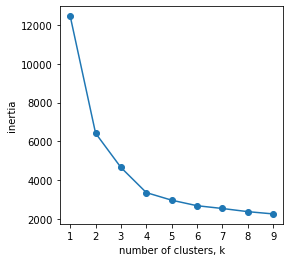

In [54]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(cluster_df)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [55]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1', 'PCA2'])

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster'] = cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers = ['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster'] == label]
            if label == -1:
                cluster_legend = 'Noise'
            else:
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,
                             edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : ' + str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()


In [56]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X_features = cluster_df.values

# KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features)

# 실루엣 스코어
silhouette_kmeans = silhouette_score(X_features, labels)
print(f"실루엣 스코어: {silhouette_kmeans:.3f}")


실루엣 스코어: 0.997


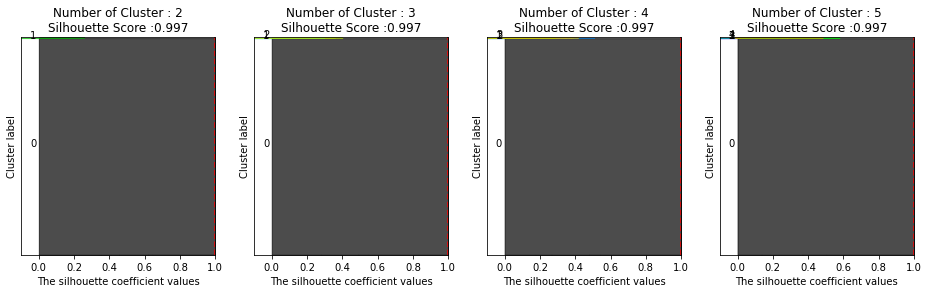

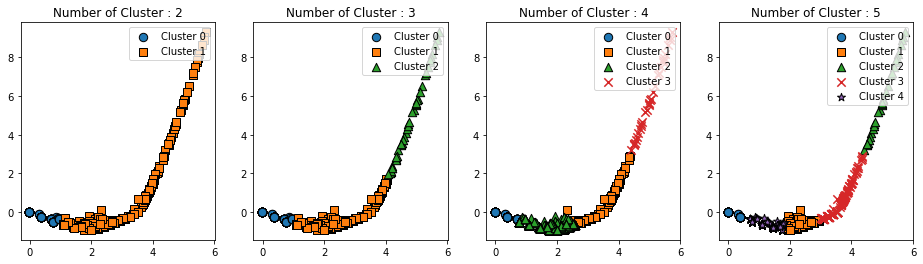

In [58]:
visualize_silhouette([2,3,4,5],X_features)
visualize_kmeans_plot_multi([2,3,4,5],X_features)

In [466]:
cluster_df.describe()

,StartLoanApply,UseLoanManage,UsePrepayCalc,UseDSRCalc,GetCreditInfo,"(StartLoanApply, UseLoanManage)","(StartLoanApply, UsePrepayCalc)","(StartLoanApply, UseDSRCalc)","(StartLoanApply, GetCreditInfo)","(UseLoanManage, StartLoanApply)",...,"(GetCreditInfo, UsePrepayCalc, UseDSRCalc, StartLoanApply, UseLoanManage)","(GetCreditInfo, UsePrepayCalc, UseDSRCalc, UseLoanManage, StartLoanApply)","(GetCreditInfo, UseDSRCalc, StartLoanApply, UseLoanManage, UsePrepayCalc)","(GetCreditInfo, UseDSRCalc, StartLoanApply, UsePrepayCalc, UseLoanManage)","(GetCreditInfo, UseDSRCalc, UseLoanManage, StartLoanApply, UsePrepayCalc)","(GetCreditInfo, UseDSRCalc, UseLoanManage, UsePrepayCalc, StartLoanApply)","(GetCreditInfo, UseDSRCalc, UsePrepayCalc, StartLoanApply, UseLoanManage)","(GetCreditInfo, UseDSRCalc, UsePrepayCalc, UseLoanManage, StartLoanApply)",,cluster_label
count,370436.000000,370436.000000,370436.000000,370436.000000,370436.000000,370436.000000,370436.000000,370436.000000,370436.000000,370436.000000,...,370436.000000,370436.0,370436.0,370436.0,370436.0,370436.0,370436.000000,370436.0,370436.0,370436.0
mean,0.012175,0.017358,0.001255,0.001228,0.017763,0.001209,0.000011,0.000016,0.001479,0.001002,...,0.000003,0.0,0.0,0.0,0.0,0.0,0.000003,0.0,0.0,0.0
std,0.246427,0.294089,0.079214,0.078358,0.297488,0.034755,0.003286,0.004025,0.038434,0.031631,...,0.001643,0.0,0.0,0.0,0.0,0.0,0.001643,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0


-> 이상한 클러스터링의 원인: 너무나 sparse한 데이터.. 이렇게는 못할듯

# 결국 유저 스펙에는 사용하기 어렵다는 결론이 나옴

---